In [1]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import json
import nltk
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /Users/ajaymdn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
def clean_text(text):
    # Ensure consistent spacing after titles like "Item 1A."
    text = re.sub(r'(Item\s*\d+[A-Za-z]*)\.', r'\1. ', text)
    # Insert missing spaces between concatenated words like "FactorsThe"
    text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)
    # Clean up spacing after punctuation
    text = re.sub(r'(?<=[.!?])(?=\S)', r' ', text)
    return text.strip()

In [4]:
def split_sentences_with_nltk(text):
    # Initial cleaning
    text = clean_text(text)

    # Use nltk's sentence tokenizer
    sentences = nltk.sent_tokenize(text)

    # Post-process to remove redundant or empty sentences
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    return sentences

In [5]:
def converttotext(url):
    headers = {'User-Agent':'Sample Company Name AdminContact@<sample company domain>.com','Accept-Encoding':'gzip, deflate','Host':'www.sec.gov'}

    r = requests.get(url, headers=headers)

    raw_10k = r.text

    doc_start_pattern = re.compile(r'<DOCUMENT>')
    doc_end_pattern = re.compile(r'</DOCUMENT>')
    type_pattern = re.compile(r'<TYPE>[^\n]+')

    doc_start_is = [x.end() for x in doc_start_pattern.finditer(raw_10k)]
    doc_end_is = [x.start() for x in doc_end_pattern.finditer(raw_10k)]

    doc_types = [x[len('<TYPE>'):] for x in type_pattern.findall(raw_10k)]

    document = {}
    
    for doc_type, doc_start, doc_end in zip(doc_types, doc_start_is, doc_end_is):
        if doc_type == '10-K':
            document[doc_type] = raw_10k[doc_start:doc_end]

    regex = re.compile(r'(>Item(\s|&#160;|&nbsp;)(1A|1B|7A|7|8)\.{0,1})|(ITEM\s(1A|1B|7A|7|8))')

    matches = regex.finditer(document['10-K'])

    test_df = pd.DataFrame([(x.group(), x.start(), x.end()) for x in matches])

    test_df.columns = ['item', 'start', 'end']
    test_df['item'] = test_df.item.str.lower()
    test_df.head()
    test_df.replace('&#160;',' ',regex=True,inplace=True)
    test_df.replace('&nbsp;',' ',regex=True,inplace=True)
    test_df.replace(' ','',regex=True,inplace=True)
    test_df.replace('\.','',regex=True,inplace=True)
    test_df.replace('>','',regex=True,inplace=True)

    pos_dat = test_df.sort_values('start', ascending=True).drop_duplicates(subset=['item'], keep='last')
    pos_dat.set_index('item', inplace=True)

    item_1a_raw = document['10-K'][pos_dat['start'].loc['item1a']:pos_dat['start'].loc['item1b']]

    item_1a_content = BeautifulSoup(item_1a_raw, 'lxml')

    item_1a_text = item_1a_content.get_text()

    # def clean_text(text):
    #     text = re.sub(r'(Item\s*\d+[A-Za-z]*)\.', r'\1. ', text)
    #     text = re.sub(r'(?<=[.!?])(?=\S)', r' ', text)
    #     return text.strip()

    # item_1a_text_cleaned = clean_text(item_1a_text)

    # item_1a_text_cleaned = re.sub(r'(?<=[.!?])(?=\S)', r' ', item_1a_text_cleaned)


    # sentence_splitter = re.compile(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<!\.\.\.)(?<=\.|\?)\s')

    # sentences = sentence_splitter.split(item_1a_text_cleaned)
    # sentences = [sentence.strip() for sentence in sentences if sentence.strip()]

    sentences = split_sentences_with_nltk(item_1a_text)
    
    return sentences


In [6]:
# sentences = converttotext('https://www.sec.gov/Archives/edgar/data/0001018724/000101872424000008/0001018724-24-000008.txt')
# print(len(sentences))
# finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-esg',num_labels=4)
# tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-esg')
# nlp = pipeline("text-classification", model=finbert, tokenizer=tokenizer)
# results = nlp(sentences)

# environment_score = [entry['score'] for entry in results if entry['label'] == 'Environmental']
# social_score = [entry['score'] for entry in results if entry['label'] == 'Social']
# governance_score = [entry['score'] for entry in results if entry['label'] == 'Governance']

# environment_score_avg = sum(environment_score) / len(environment_score) if environment_score else 0
# social_score_avg = sum(social_score) / len(social_score) if social_score else 0
# governance_score_avg = sum(governance_score) / len(governance_score) if governance_score else 0

# print(f'Average Environmental Score: {environment_score_avg}')
# print(f'Average Social Score: {social_score_avg}')
# print(f'Average Governance Score: {governance_score_avg}')

In [12]:
def calculate_average_esg(sentences, nlp):
    results = nlp(sentences)

    # Extract scores for each category
    environment_score = [entry['score'] for entry in results if entry['label'] == 'Environmental']
    social_score = [entry['score'] for entry in results if entry['label'] == 'Social']
    governance_score = [entry['score'] for entry in results if entry['label'] == 'Governance']

    # Calculate averages or set to 0 if no scores are found
    environment_score_avg = sum(environment_score) / len(environment_score) if environment_score else 0
    social_score_avg = sum(social_score) / len(social_score) if social_score else 0
    governance_score_avg = sum(governance_score) / len(governance_score) if governance_score else 0

    return {
        'environment_score_avg': environment_score_avg,
        'social_score_avg': social_score_avg,
        'governance_score_avg': governance_score_avg
    }

In [13]:
# finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-esg',num_labels=4)
# tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-esg')
# nlp = pipeline("text-classification", model=finbert, tokenizer=tokenizer, truncation=True, max_length=512)

# target_year = 2024

# with open(f"../Edgar/10K-URL/All_10K_Filings_{target_year}.json", "r") as read_file:
#     companies = json.load(read_file)

# valid_companies = []

# for company in companies:
#     try:
#         print(f"Analysing: {company['company']}")
#         sentences = converttotext(company['url'])
#         print(f"Number of sentences: {len(sentences)}")

#         if len(sentences) > 10:
#             scores = calculate_average_esg(sentences, nlp)
        
#             company['environment_score_avg'] = scores['environment_score_avg']
#             company['social_score_avg'] = scores['social_score_avg']
#             company['governance_score_avg'] = scores['governance_score_avg']
        
#             valid_companies.append(company)

#     except Exception as e:
#         print(f"Error processing {company['company']}: {e}")

# final_companies = [company['company'] for company in valid_companies]
# print(f"Companies processed: {final_companies}")

# if valid_companies:
#     environment_avg = sum([company['environment_score_avg'] for company in valid_companies]) / len(valid_companies)
#     social_avg = sum([company['social_score_avg'] for company in valid_companies]) / len(valid_companies)
#     governance_avg = sum([company['governance_score_avg'] for company in valid_companies]) / len(valid_companies)

#     print(f'Average Environmental Score: {environment_avg}')
#     print(f'Average Social Score: {social_avg}')
#     print(f'Average Governance Score: {governance_avg}')
# else:
#     print("No valid companies to calculate averages.")

In [15]:
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-esg',num_labels=4)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-esg')
nlp = pipeline("text-classification", model=finbert, tokenizer=tokenizer, truncation=True, max_length=512, device=-1)

target_years = range(2014, 2025)
industry = "OIL"

environment_scores = []
social_scores = []
governance_scores = []

for target_year in tqdm(target_years):
    print(f"Processing year: {target_year}")

    try:
        with open(f"../Edgar/10K_URL_{industry}/All_10K_Filings_{target_year}.json", "r") as read_file:
            companies = json.load(read_file)

        valid_companies = []

        for company in tqdm(companies):
            try:
                sentences = converttotext(company['url'])
                print(f"Company: {company['company']}, Sentence count: {len(sentences)}")

                if len(sentences) > 10:
                    scores = calculate_average_esg(sentences, nlp)
                
                    company['environment_score_avg'] = scores['environment_score_avg']
                    company['social_score_avg'] = scores['social_score_avg']
                    company['governance_score_avg'] = scores['governance_score_avg']
                
                    valid_companies.append(company)

            except Exception as e:
                print(f"Error processing {company['company']}: {e}")

        final_companies = [company['company'] for company in valid_companies]
        print(f"Companies processed: {final_companies}")

        if valid_companies:
            environment_avg = sum([company['environment_score_avg'] for company in valid_companies]) / len(valid_companies)
            social_avg = sum([company['social_score_avg'] for company in valid_companies]) / len(valid_companies)
            governance_avg = sum([company['governance_score_avg'] for company in valid_companies]) / len(valid_companies)

            environment_scores.append(environment_avg)
            social_scores.append(social_avg)
            governance_scores.append(governance_avg)

    except Exception as e:
        print(f"Error processing year {target_year}: {e}")

  0%|          | 0/11 [00:00<?, ?it/s]

Processing year: 2014


Company: XOM, Sentence count: 2


Error processing CVX: 'item1b'
Company: COP, Sentence count: 62


Error processing EOG: Length mismatch: Expected axis has 0 elements, new values have 3 elements
Company: OXY, Sentence count: 48


Company: PSX, Sentence count: 183


Company: MPC, Sentence count: 208


Error processing VLO: 'item1a'


Error processing HES: 'item1b'
Company: DVN, Sentence count: 100


Company: KMI, Sentence count: 327


Company: WMB, Sentence count: 268


Error processing HAL: 'item1a'
Company: EXE, Sentence count: 811


  9%|▉         | 1/11 [01:44<17:28, 104.84s/it]

Companies processed: ['COP', 'OXY', 'PSX', 'MPC', 'DVN', 'KMI', 'WMB', 'EXE']
Processing year: 2015


Company: XOM, Sentence count: 2
Company: CVX, Sentence count: 50


Company: COP, Sentence count: 64


Error processing EOG: Length mismatch: Expected axis has 0 elements, new values have 3 elements
Company: OXY, Sentence count: 59


Company: PSX, Sentence count: 182


Company: MPC, Sentence count: 246


Company: VLO, Sentence count: 138


Error processing HES: 'item1b'
Company: DVN, Sentence count: 104


Company: KMI, Sentence count: 259


Company: WMB, Sentence count: 304


Error processing HAL: 'item1a'
Company: EXE, Sentence count: 775


 18%|█▊        | 2/11 [03:41<16:46, 111.80s/it]

Companies processed: ['CVX', 'COP', 'OXY', 'PSX', 'MPC', 'VLO', 'DVN', 'KMI', 'WMB', 'EXE']
Processing year: 2016


Company: XOM, Sentence count: 2
Company: CVX, Sentence count: 57


Company: COP, Sentence count: 102


Error processing EOG: Length mismatch: Expected axis has 0 elements, new values have 3 elements
Company: OXY, Sentence count: 69


Company: PSX, Sentence count: 190


Company: MPC, Sentence count: 269


Company: VLO, Sentence count: 0


Company: HES, Sentence count: 0
Company: DVN, Sentence count: 132


Company: KMI, Sentence count: 279


Company: WMB, Sentence count: 347


Error processing HAL: 'item1a'
Company: EXE, Sentence count: 842


 27%|██▋       | 3/11 [05:31<14:46, 110.80s/it]

Companies processed: ['CVX', 'COP', 'OXY', 'PSX', 'MPC', 'DVN', 'KMI', 'WMB', 'EXE']
Processing year: 2017


Company: XOM, Sentence count: 2
Company: CVX, Sentence count: 74


Company: COP, Sentence count: 116


Error processing EOG: Length mismatch: Expected axis has 0 elements, new values have 3 elements
Company: OXY, Sentence count: 70


Company: PSX, Sentence count: 190


Company: MPC, Sentence count: 268


Company: VLO, Sentence count: 0


Company: HES, Sentence count: 0
Company: DVN, Sentence count: 150


Company: KMI, Sentence count: 279


Company: WMB, Sentence count: 320


Error processing HAL: 'item1a'
Company: EXE, Sentence count: 804


 36%|███▋      | 4/11 [07:21<12:54, 110.60s/it]

Companies processed: ['CVX', 'COP', 'OXY', 'PSX', 'MPC', 'DVN', 'KMI', 'WMB', 'EXE']
Processing year: 2018


Company: XOM, Sentence count: 2
Company: CVX, Sentence count: 75


Company: COP, Sentence count: 121


Error processing EOG: Length mismatch: Expected axis has 0 elements, new values have 3 elements
Company: OXY, Sentence count: 78


Company: PSX, Sentence count: 190


Company: MPC, Sentence count: 255


Company: VLO, Sentence count: 0


Company: HES, Sentence count: 0
Company: DVN, Sentence count: 153


Company: KMI, Sentence count: 301


Company: WMB, Sentence count: 285


Error processing HAL: 'item1a'
Company: BKR, Sentence count: 235


Company: EXE, Sentence count: 718


 45%|████▌     | 5/11 [09:17<11:14, 112.47s/it]

Companies processed: ['CVX', 'COP', 'OXY', 'PSX', 'MPC', 'DVN', 'KMI', 'WMB', 'BKR', 'EXE']
Processing year: 2019


Company: XOM, Sentence count: 2
Company: CVX, Sentence count: 76


Company: COP, Sentence count: 159


Error processing EOG: Length mismatch: Expected axis has 0 elements, new values have 3 elements
Company: OXY, Sentence count: 85


Company: PSX, Sentence count: 195


Company: MPC, Sentence count: 2


Company: VLO, Sentence count: 0


Company: HES, Sentence count: 0
Company: DVN, Sentence count: 159


Company: KMI, Sentence count: 346


Company: WMB, Sentence count: 256


Error processing HAL: 'item1a'
Company: BKR, Sentence count: 261


Company: EXE, Sentence count: 770


 55%|█████▍    | 6/11 [11:06<09:16, 111.33s/it]

Companies processed: ['CVX', 'COP', 'OXY', 'PSX', 'DVN', 'KMI', 'WMB', 'BKR', 'EXE']
Processing year: 2020


Company: XOM, Sentence count: 107


Company: CVX, Sentence count: 83


Company: COP, Sentence count: 157


Error processing EOG: Length mismatch: Expected axis has 0 elements, new values have 3 elements
Company: OXY, Sentence count: 163


Company: PSX, Sentence count: 194


Company: MPC, Sentence count: 2


Company: VLO, Sentence count: 0


Company: HES, Sentence count: 0
Company: DVN, Sentence count: 145


Company: KMI, Sentence count: 344


Company: WMB, Sentence count: 289


Error processing HAL: 'item1a'
Company: BKR, Sentence count: 215


Company: EXE, Sentence count: 745


 64%|██████▎   | 7/11 [13:08<07:39, 114.87s/it]

Companies processed: ['XOM', 'CVX', 'COP', 'OXY', 'PSX', 'DVN', 'KMI', 'WMB', 'BKR', 'EXE']
Processing year: 2021


Company: XOM, Sentence count: 110


Company: CVX, Sentence count: 118


Company: COP, Sentence count: 198


Company: EOG, Sentence count: 0
Company: OXY, Sentence count: 186


Company: PSX, Sentence count: 244


Company: MPC, Sentence count: 2


Company: VLO, Sentence count: 0


Company: HES, Sentence count: 0
Company: DVN, Sentence count: 165


Company: KMI, Sentence count: 367


Company: WMB, Sentence count: 300


Error processing HAL: 'item1a'
Company: BKR, Sentence count: 250


Company: EXE, Sentence count: 767


 73%|███████▎  | 8/11 [15:12<05:53, 117.80s/it]

Companies processed: ['XOM', 'CVX', 'COP', 'OXY', 'PSX', 'DVN', 'KMI', 'WMB', 'BKR', 'EXE']
Processing year: 2022


Company: XOM, Sentence count: 129


Company: CVX, Sentence count: 104


Company: COP, Sentence count: 0


Company: EOG, Sentence count: 0
Company: OXY, Sentence count: 203


Company: PSX, Sentence count: 267


Company: MPC, Sentence count: 2


Error processing VLO: Length mismatch: Expected axis has 0 elements, new values have 3 elements


Company: HES, Sentence count: 0
Company: DVN, Sentence count: 181


Company: KMI, Sentence count: 368


Company: WMB, Sentence count: 304


Error processing HAL: 'item1a'
Company: BKR, Sentence count: 222


Company: EXE, Sentence count: 437


 82%|████████▏ | 9/11 [16:55<03:46, 113.22s/it]

Companies processed: ['XOM', 'CVX', 'OXY', 'PSX', 'DVN', 'KMI', 'WMB', 'BKR', 'EXE']
Processing year: 2023


Company: XOM, Sentence count: 134


Company: CVX, Sentence count: 111


Company: COP, Sentence count: 182


Company: EOG, Sentence count: 0
Company: OXY, Sentence count: 259


Company: PSX, Sentence count: 280


Company: MPC, Sentence count: 340


Company: VLO, Sentence count: 2


Company: HES, Sentence count: 0
Company: DVN, Sentence count: 190


Company: KMI, Sentence count: 354


Company: WMB, Sentence count: 296


Error processing HAL: 'item1a'
Company: BKR, Sentence count: 255


Company: EXE, Sentence count: 331


 91%|█████████ | 10/11 [19:01<01:56, 116.97s/it]

Companies processed: ['XOM', 'CVX', 'COP', 'OXY', 'PSX', 'MPC', 'DVN', 'KMI', 'WMB', 'BKR', 'EXE']
Processing year: 2024


Company: XOM, Sentence count: 135


Company: CVX, Sentence count: 0


Company: COP, Sentence count: 0


Company: EOG, Sentence count: 0
Company: OXY, Sentence count: 379


Company: PSX, Sentence count: 296


Company: MPC, Sentence count: 348


Company: VLO, Sentence count: 2


Company: HES, Sentence count: 0
Company: DVN, Sentence count: 197


Company: KMI, Sentence count: 360


Company: WMB, Sentence count: 297


Error processing HAL: 'item1a'
Company: BKR, Sentence count: 275


Company: EXE, Sentence count: 494


100%|██████████| 11/11 [21:11<00:00, 115.58s/it]

Companies processed: ['XOM', 'OXY', 'PSX', 'MPC', 'DVN', 'KMI', 'WMB', 'BKR', 'EXE']


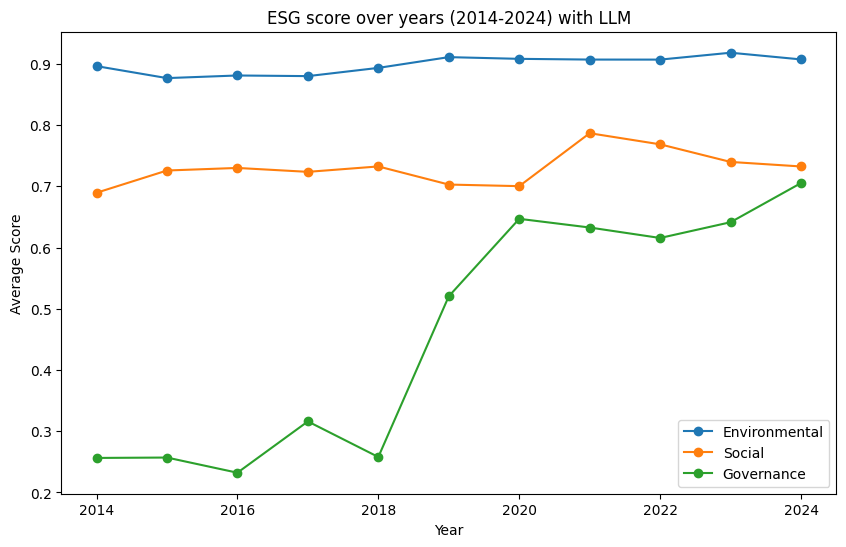

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(target_years, environment_scores, label='Environmental', marker='o')
plt.plot(target_years, social_scores, label='Social', marker='o')
plt.plot(target_years, governance_scores, label='Governance', marker='o')

plt.title("ESG score over years (2014-2024) with LLM")
plt.xlabel("Year")
plt.ylabel("Average Score")
plt.legend()
plt.show()